In [1]:
import sys
sys.path.insert(0, '../util')
sys.path.insert(0, '../')
import matplotlib.pyplot as plt
from sc import *
from plot import *
from tqdm import tqdm
from alg import hstar, k_rollout, bhattacharya, almost_equal
from pqdict import pqdict
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

# make scs

In [2]:
folder = "../exp3_data2"

def get_hole_coords(n_side, row_col_coords):
    delta = 2 / (n_side - 1)
    return np.array([np.array(x) * delta - (1, 1) for x in row_col_coords])

n_side = 19

node_coords = [(n_side//2,n_side//2), (4, 4),  (n_side-5, 4),  (n_side-5, n_side-5),  (4, n_side-5), (4, n_side//2), (n_side-5, n_side//2), (n_side//2, 4), (n_side//2, n_side-5)]
hole_locs = get_hole_coords(n_side, node_coords)

num_scs = len(hole_locs)
dx = 2 / (n_side - 1)
SCs = []

for i, loc in enumerate(hole_locs):
    SC_i = SimplicialComplex(n_side, False, False, True)
    SC_i.make_holes(hole_locs[:i+1,:], 1.5*dx)
    SCs.append(SC_i)

coords = [(-1, -1), (1, -1), (1,0), (-1, 0), (-1, 1), (1,1)]
ref_outputs = [Path(SC_i, path_from_coords(SCs[-1], coords)) for SC_i in SCs]

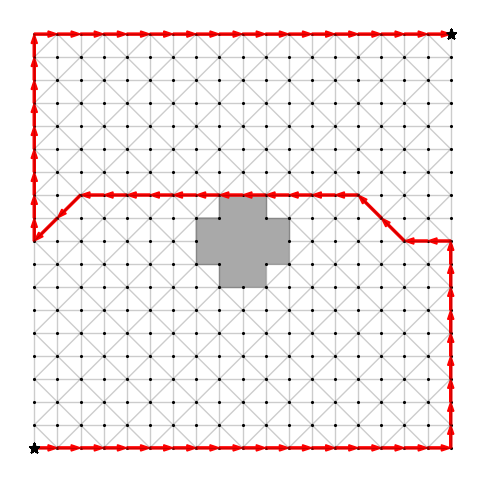

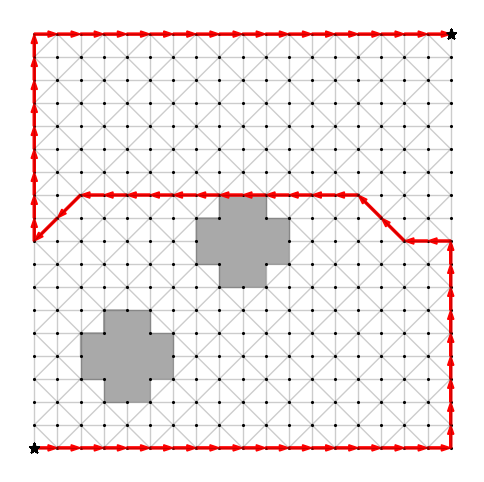

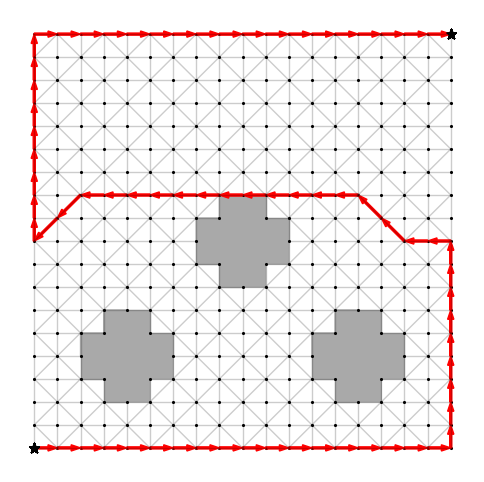

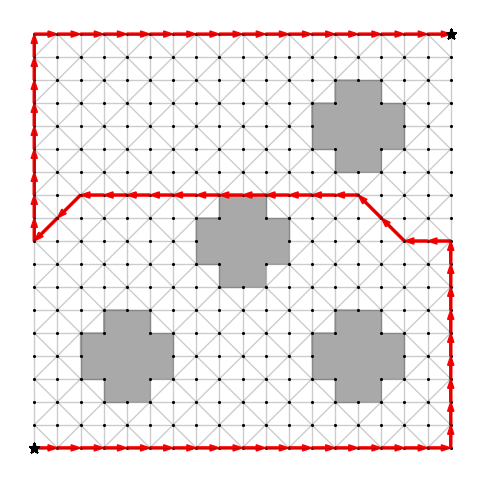

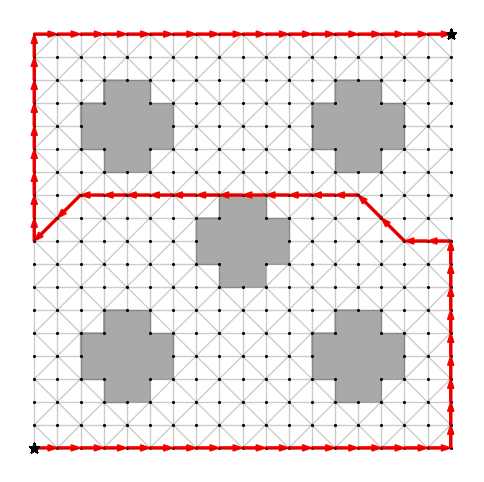

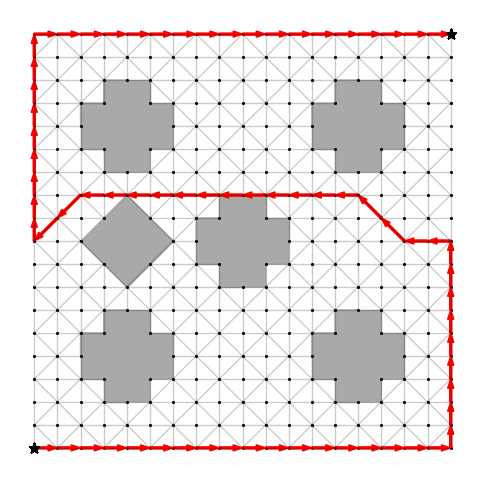

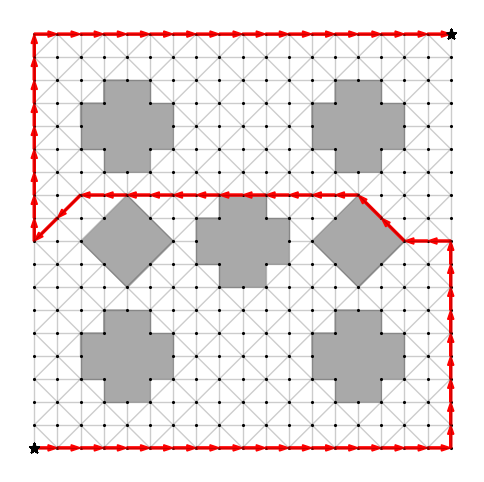

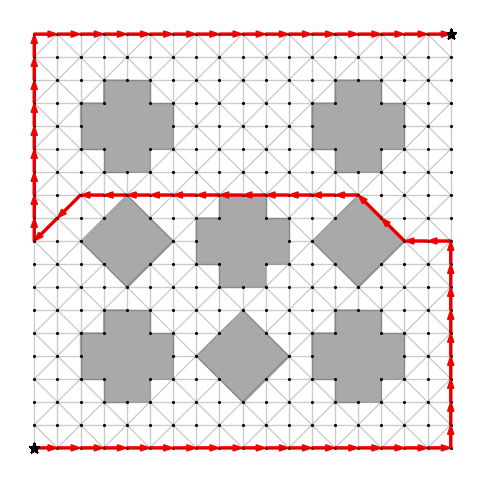

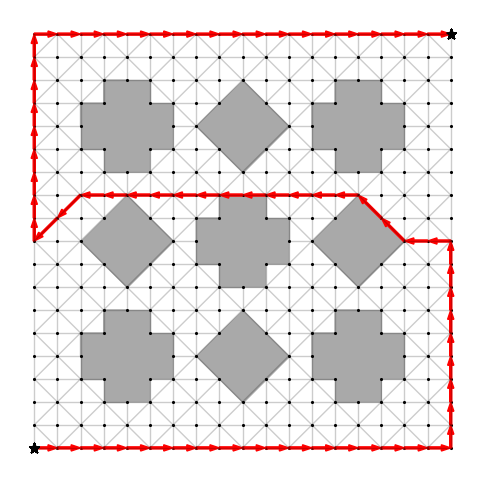

In [3]:
for i, SC_i in enumerate(SCs):
    plot_path(SC_i, ref_outputs[i], 'red', '')
    plt.show()

In [5]:
alphas = np.linspace(0, 3, 20)
np.savez(f"{folder}/setup", alphas=alphas, SCs=SCs, ref_outputs=ref_outputs, hole_locs=hole_locs)

# Get data

In [6]:
results_dict = np.load(f"{folder}/setup.npz", allow_pickle=True)
alphas, SCs, ref_outputs, hole_locs = [results_dict[x] for x in results_dict.keys()]

In [6]:
eps = 1e-4
num_SCs = len(SCs)
inputs1 = [(x[0], x[1], x[2], alphas, 0, False, eps, folder) for x in zip(range(len(SCs)), SCs, ref_outputs)]
inputs2 = [(x[0], x[1], x[2], alphas, 1, False, eps, folder) for x in zip(range(len(SCs)), SCs, ref_outputs)]
inputs3 = [(x[0], x[1], x[2], alphas, 1, True,  eps, folder) for x in zip(range(len(SCs)), SCs, ref_outputs)]

In [7]:
from wrapper import exp2_wrapper as wrap

In [8]:
# Base heuristic 
pool = Pool(4)
res = pool.map_async(wrap, inputs1).get()
pool.terminate()

100%|███| 20/20 [00:08<00:00,  2.47it/s]


In [9]:
# One step lookahead no pruning
pool = Pool(4)
res = pool.map_async(wrap, inputs2).get()
pool.terminate()

100%|███| 20/20 [05:23<00:00, 16.18s/it]


In [10]:
# One step lookahead w/ pruning
pool = Pool(4)
res = pool.map_async(wrap, inputs3).get()
pool.terminate()

100%|███| 20/20 [03:43<00:00, 11.20s/it]


In [11]:
from wrapper import bhattacharya_wrapper as bhat_wrap

bhat_inputs = []
for i, (SC, ref_path, locs) in tqdm(enumerate(zip(SCs, ref_outputs, hole_locs))):
    start, end = ref_path[0], ref_path[-1]
    bhat_inputs.append([SC, ref_path, 1e-7, True, i, folder])

9it [00:00, 44779.05it/s]


In [12]:
pool = Pool(processes=4)
data_bhat = pool.starmap(bhat_wrap, bhat_inputs)
pool.terminate()

/Users/ctaveras/opt/anaconda3/envs/ot-simp/lib/python3.9/site-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)
/Users/ctaveras/opt/anaconda3/envs/ot-simp/lib/python3.9/site-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)
/Users/ctaveras/opt/anaconda3/envs/ot-simp/lib/python3.9/site-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarr

# Process Data

In [3]:
folder = "../exp3_data2"
results_dict = np.load(f"{folder}/setup.npz", allow_pickle=True)
alphas, SCs, ref_outputs, hole_locs = [results_dict[x] for x in results_dict.keys()]

N = 9

data_reg   = [np.load(f"{folder}/data_steps0_batch{i}.npz", allow_pickle=True)["data"] for i in range(N)]
data_roll  = [np.load(f"{folder}/data_steps1_batch{i}.npz", allow_pickle=True)["data"] for i in range(N)]
data_prune = [np.load(f"{folder}/data_prune_steps1_batch{i}.npz", allow_pickle=True)["data"] for i in range(N)]
data_bhat  = [np.load(f"{folder}/data_bhat_batch_{i}.npz", allow_pickle=True)["data"] for i in range(N)]

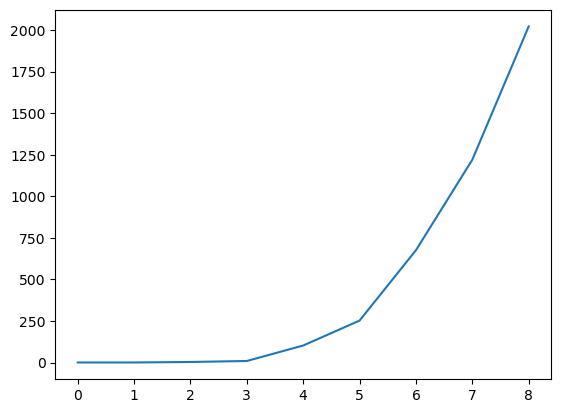

In [30]:
plt.plot([len(x[1]) for x in data_bhat])
plt.show()

In [60]:
def get_transitions(path_arr, ref_path, eps=1e-10):
    proj_arr = np.array([ref_path.proj_diff(x) for x in path_arr])
    # np.linalg.norm(x.proj - ref_path.proj, 2) for x in path_arr])
    proj_grad = proj_arr[:-1] - proj_arr[1:]
    transitions = [0] + list(np.where(proj_grad > eps)[0] + 1) + [len(path_arr)]
    return transitions

def identify_class(heuristic_paths, bhat_paths, eps=1e-5):
    corresponding_shortest = []
    for i, path_i in enumerate(heuristic_paths):
        for j, path_j in enumerate(bhat_paths):
            if almost_equal(path_i.proj, path_j.proj, eps):
                corresponding_shortest.append(path_j)
                break
    return corresponding_shortest

def get_best_paths(paths, bounds, num_visited, eps=1e-5):
    best_paths, best_idxs = [], []
    path_lens = [x.weight for x in paths]
    for i, left in enumerate(bounds[:-1]):
        right = bounds[i+1]
        sub_arr = path_lens[left:right]
        best_idx = left+np.argmin(sub_arr)
        best_cost = path_lens[best_idx]
        all_nodes_w_best_cost = np.array([(left+i, num_visited[left+i]) for (i, x) in enumerate(sub_arr) if np.abs(best_cost - x) < eps])
        best_idx = int(all_nodes_w_best_cost[np.argmin(all_nodes_w_best_cost[:,1]),0])
        best_path = paths[best_idx]
        best_paths.append(best_path)
        best_idxs.append(best_idx)

    return best_paths, best_idxs

def assign_colors_to_paths(paths1, paths2, paths3, colors, decimals):
    paths = paths1 + paths2 + paths3
    color_dict = {}
    k = 1
    assigned_colors = [None] * len(paths)
    for i, x in enumerate(paths):
        proj_x = tuple(np.round(x.proj, decimals))
        if proj_x in color_dict:
            assigned_colors[i] = color_dict[proj_x]
        if proj_x not in color_dict:
            k += 1
            color_dict[proj_x] = colors[k]
            assigned_colors[i] = colors[k]

    n1, n2, n3 = len(paths1), len(paths2), len(paths3)

    path1_colors = colors[:2] + assigned_colors[:n1]
    path2_colors = colors[:2] + assigned_colors[n1:n1+n2]
    path3_colors = colors[:2] + assigned_colors[n1+n2:]

    return path1_colors, path2_colors, path3_colors, color_dict

In [61]:
# num_SCs = len(SCs)
data_to_plot = np.zeros((N, 4, 3), object)

for i, (SC, ref_path_arr)  in enumerate(zip(SCs[:N], ref_outputs[:N])):
    ref_path = Path(SC, ref_path_arr)
    for j in range(3):
        alphas_j = alphas
        data_ij = (data_reg[i]) if (j == 0) else (data_roll[i] if (j == 1) else data_prune[i])
        paths_ij = [data_ij[k][0] for k in range(len(data_ij))]
        num_visited_ij = data_ij[:,3]
        path_proj_diffs = [ref_path.proj_diff(x) for x in paths_ij]
        trans_ij = get_transitions(paths_ij, ref_path)
        best_paths_ij, best_paths_idx = get_best_paths(paths_ij, trans_ij, num_visited_ij)
        best_data = [(alphas_j[k], np.round(paths_ij[k].weight, 2), np.round(path_proj_diffs[k], 2), data_ij[k][-1]) for k in best_paths_idx]
        data_to_plot[i,j,0] = data_ij[best_paths_idx[-1]][-2]
        data_to_plot[i,j,1] = paths_ij[best_paths_idx[-1]].weight
        data_to_plot[i,j,2] = paths_ij[best_paths_idx[-1]]
    data_to_plot[i,3,0] = data_bhat[i][-2]
    data_to_plot[i,3,1] = data_bhat[i][0].weight
    data_to_plot[i,3,2] = data_bhat[i][0]

In [109]:
i, j = 3, 2
ref_path = Path(SCs[i], ref_outputs[i])
data_ij = (data_reg[3]) if (j == 0) else (data_roll[i] if (j == 1) else data_prune[i])
num_visited_ij = data_ij[:,3]
paths_ij = [data_ij[k][0] for k in range(len(data_ij))]
path_proj_diffs = [ref_path.proj_diff(x) for x in paths_ij]
trans_ij = get_transitions(paths_ij, ref_path)
# best_paths_ij, best_paths_idx = get_best_paths(paths_ij, trans_ij, num_visited_ij)

In [111]:
ref_path.proj.shape,

((4,),
 [7.63197581665913e-15,
  7.63197581665913e-15,
  7.98985837807101e-15,
  6.38987364452437e-15,
  6.278468263019268e-15,
  6.147719026489021e-15,
  6.717437072128746e-15,
  6.717437072128746e-15,
  6.5924166544643585e-15,
  7.148892893116676e-15,
  6.6242854878769026e-15,
  7.148892893116676e-15,
  7.148892893116676e-15,
  7.148892893116676e-15,
  7.780489869216079e-15,
  9.008138237051454e-15,
  9.956207786785866e-15,
  1.1029559027641372e-14,
  1.1029559027641372e-14,
  1.1029559027641372e-14])

In [107]:
print(path_proj_diffs)

[7.63197581665913e-15, 7.63197581665913e-15, 7.98985837807101e-15, 6.38987364452437e-15, 6.278468263019268e-15, 6.147719026489021e-15, 6.717437072128746e-15, 6.717437072128746e-15, 6.5924166544643585e-15, 7.148892893116676e-15, 6.6242854878769026e-15, 7.148892893116676e-15, 7.148892893116676e-15, 7.148892893116676e-15, 7.780489869216079e-15, 9.008138237051454e-15, 9.956207786785866e-15, 1.1029559027641372e-14, 1.1029559027641372e-14, 1.1029559027641372e-14]


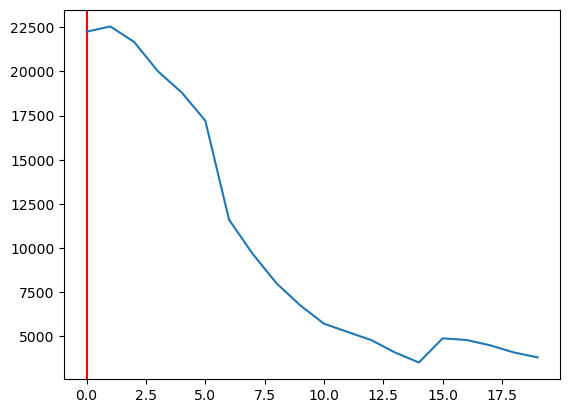

In [103]:
plt.axvline(trans_ij[-2], c='r')
plt.plot(num_visited_ij)

In [81]:
path_proj_diffs

[1.0375092081891894e-14,
 9.952609150354711e-15,
 9.378756443156728e-15,
 1.0551792321731856e-14,
 1.0180206354657573e-14,
 9.817787014225374e-15,
 9.224877785137138e-15,
 8.955206467987463e-15,
 9.224877785137138e-15,
 8.955206467987463e-15,
 9.224877785137138e-15,
 8.955206467987463e-15,
 8.955206467987463e-15,
 8.955206467987463e-15,
 8.955206467987463e-15,
 8.955206467987463e-15,
 8.955206467987463e-15,
 8.955206467987463e-15,
 8.955206467987463e-15,
 8.955206467987463e-15]

In [68]:
colors = ['#4daf4a', '#984ea3', '#f781bf', '#ff7f00', '#377eb8', '#ff7f00', '#a65628', '#999999', '#e41a1c', '#dede00']

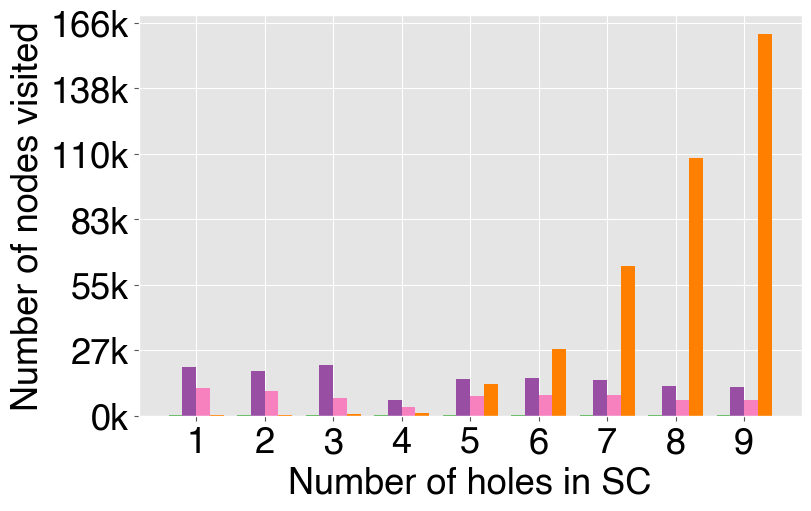

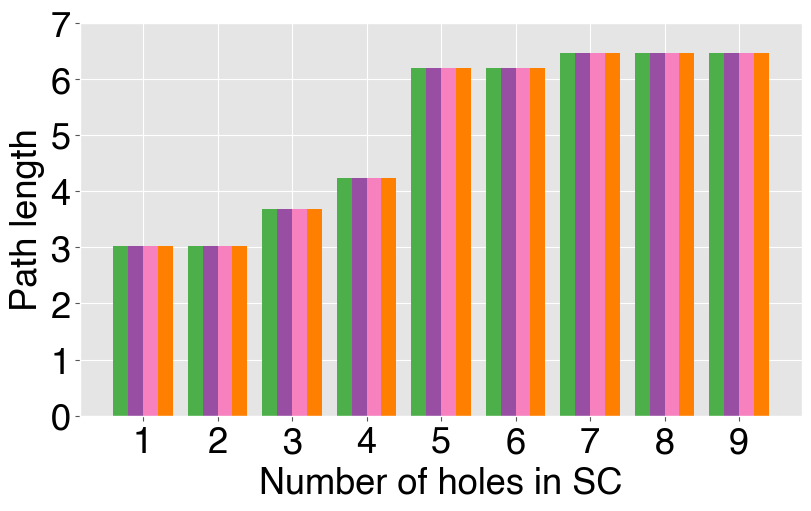

In [69]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
matplotlib.style.use('ggplot')

width = 0.2
x = np.arange(1,1+N) - 1.5 * width
multiplier = 0
fig1, ax1 = plt.subplots(layout='constrained', figsize=(8,5))
fig2, ax2 = plt.subplots(layout='constrained', figsize=(8,5))

labels = ["heuristic", "heuristic w/ rollout", "heuristic w/ rollout & pruning", "Bhattacharya et al."]
for i in range(4):
    measurement = data_to_plot[i,]
    offset = width * multiplier
    rects = ax1.bar(x + offset, data_to_plot[:,i,0], width, label=labels[i], color=colors[i])
    rects = ax2.bar(x + offset, data_to_plot[:,i,1], width, label=labels[i], color=colors[i])
    multiplier += 1

font = {'family': 'Helvetica',
    'color':  'black',
    'weight': 'normal',
    'size': 26}

plt.rcParams.update({
"text.usetex": False,
"font.family": "sans-serif",
"font.sans-serif": ["Helvetica"]})


ax1.set_xlabel("Number of holes in SC", fontdict=font)
ax1.set_ylabel("Number of nodes visited",  fontdict=font)
ax1.set_xticks(np.arange(1,N+1))
ax1.set_xticklabels([str(i) for i in range(1, N+1)], fontdict=font)
yticks = np.linspace(0, 166000, 7)
ax1.set_yticks(yticks)
ax1.set_yticklabels([str(int(i/1000)) + 'k'  for i in yticks], fontdict=font)


ax2.set_xlabel("Number of holes in SC", fontdict=font)
# ax2.set_ylim(0, 7.5)
ax2.set_ylabel("Path length",  fontdict=font)
xticks, yticks = np.arange(1,N+1), np.linspace(0, 7, 8).astype(int)
ax2.set_xticks(xticks)
ax2.set_xticklabels([str(i) for i in xticks], fontdict=font)
ax2.set_yticks(yticks)
ax2.set_yticklabels([str(i) for i in yticks], fontdict=font)

plt.show()

In [35]:
print(data_to_plot[2,:,0])
print(data_to_plot[3,:,0])
print(data_to_plot[4,:,0])

[254 21336 7435 741]
[214 6524 3530 1249]
[227 15415 8515 13540]


In [25]:
print(data_to_plot[:,1,0].T)

[20465 18839 21336 6524 15415 15831 15247 12530 12227]


[(3.023689270621825, 0.0), (3.0236892706218255, 0.0), (3.0236892706218255, 0.0), (3.023689270621825, 0.0)]
[(3.0236892706218255, 0.0), (3.023689270621825, 0.0), (3.023689270621825, 0.0), (3.023689270621825, 0.0)]
[(3.674563090207275, 0.0), (3.6745630902072746, 0.0), (3.6745630902072746, 0.0), (3.674563090207275, 0.0)]
[(4.238015069303438, 0.0), (4.238015069303438, 0.0), (4.238015069303438, 0.0), (4.238015069303438, 0.0)]
[(6.19988776369148, 0.0), (6.19988776369148, 0.0), (6.19988776369148, 0.0), (6.19988776369148, 0.0)]
[(6.19988776369148, 0.0), (6.19988776369148, 0.0), (6.19988776369148, 0.0), (6.19988776369148, 0.0)]
[(6.46023729152566, 0.0), (6.460237291525658, 0.0), (6.460237291525658, 0.0), (6.46023729152566, 0.0)]
[(6.46023729152566, 0.0), (6.460237291525658, 0.0), (6.460237291525658, 0.0), (6.46023729152566, 0.0)]
[(6.46023729152566, 0.0), (6.460237291525658, 0.0), (6.460237291525658, 0.0), (6.46023729152566, 0.0)]


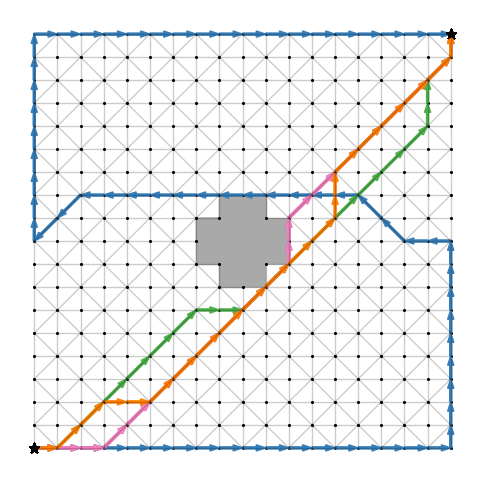

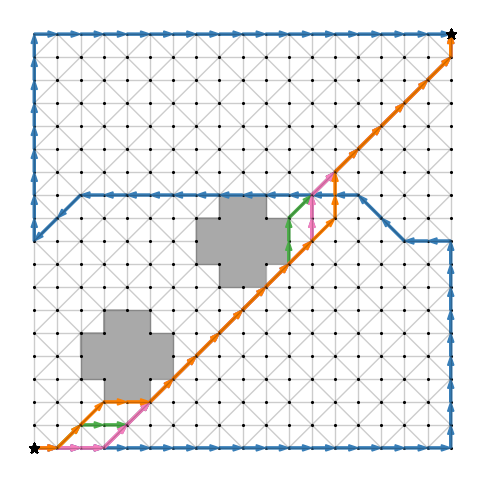

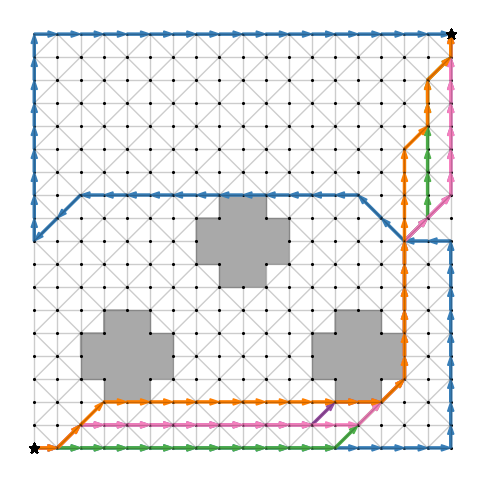

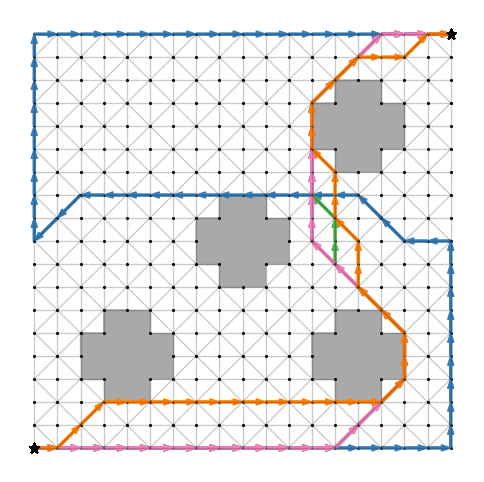

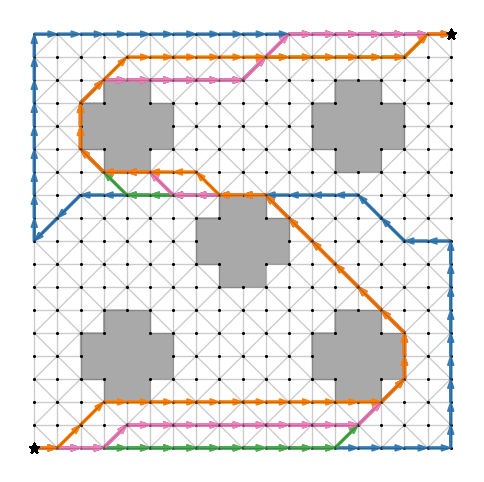

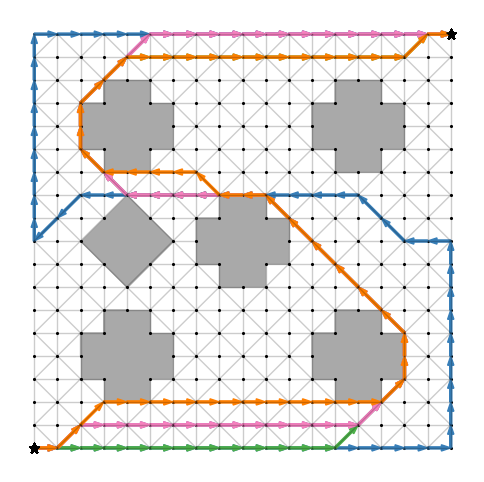

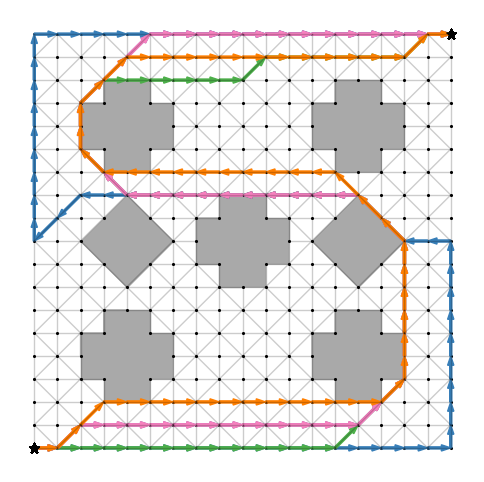

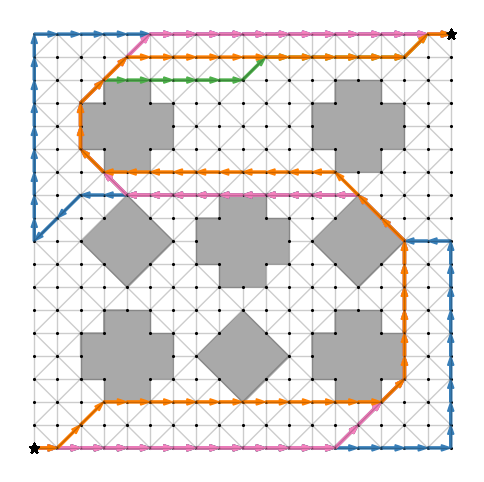

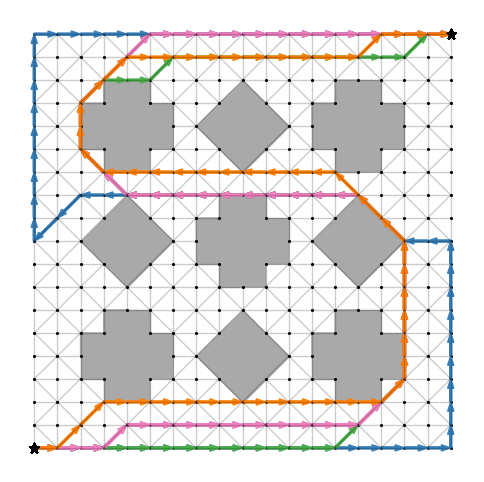

In [13]:
colors = ['#4daf4a', '#984ea3', '#f781bf', '#ff7f00', '#377eb8', '#ff7f00', '#a65628', '#999999', '#e41a1c', '#dede00']

for i, SC_i, data_i, ref_i in zip(range(len(SCs)), SCs, data_to_plot, ref_outputs):
    ref_i = Path(SC_i, ref_i)
    paths_i = data_i[:,2]
    print([(p.weight, np.round(p.proj_diff(ref_i), 3))  for p in paths_i])
    several_path_plot(SC_i, [ref_path] + list(paths_i), None, None, [colors[4]] + colors)

plt.show()